<a href="https://colab.research.google.com/github/Sunny20235195/stock-market-price-prediction/blob/main/_stock_prediction_kdaysusing_LSTM_with_Hill_climbing_vs_steal_anealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**: Khai báo các thư viện cần thiết

In [ ]:
import numpy as np # thư viện tính toán số học
import pandas as pd # thư viện giúp đọc file và xử lí dữ liệu dạng bảng
import yfinance as yf # thư viện lấy dữ liệu
import tensorflow as tf # thư viện model
from tensorflow.keras.models import Sequential # Sắp xếp các lớp
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout # Các lớp sử dụng trong mô hình
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error # Tính độ lỗi
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị
import random # random

**Step 2**: Tiền xử lí dữ liệu

In [ ]:
# Tải dữ liệu 10 năm dùng thư viện yfinance
def download_stock_data(ticker):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [ ]:
# Ví dụ về 1 mã cổ phiếu
data = download_stock_data("GOOG")


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-24,NaN,NaN,NaN,NaN,NaN
2025-05-25,NaN,NaN,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN
2025-05-27,173.979996,174.289993,171.210007,171.300003,24341300.0
2025-05-28,173.380005,176.479996,173.014999,173.979996,25999200.0
2025-05-29,172.960007,175.399994,171.779999,175.000000,21233600.0
2025-05-30,172.850006,173.440002,168.524994,172.410004,36233600.0
2025-05-31,NaN,NaN,NaN,NaN,NaN


In [ ]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

<ipython-input-44-9c6261708f8c>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-24,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-25,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-26,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-27,173.979996,174.289993,171.210007,171.300003,24341300.0
2025-05-28,173.380005,176.479996,173.014999,173.979996,25999200.0
2025-05-29,172.960007,175.399994,171.779999,175.000000,21233600.0
2025-05-30,172.850006,173.440002,168.524994,172.410004,36233600.0
2025-05-31,172.850006,173.440002,168.524994,172.410004,36233600.0


In [ ]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,GOOG
Date,
2025-05-24,169.589996
2025-05-25,169.589996
2025-05-26,169.589996
2025-05-27,173.979996
2025-05-28,173.380005
2025-05-29,172.960007
2025-05-30,172.850006
2025-05-31,172.850006


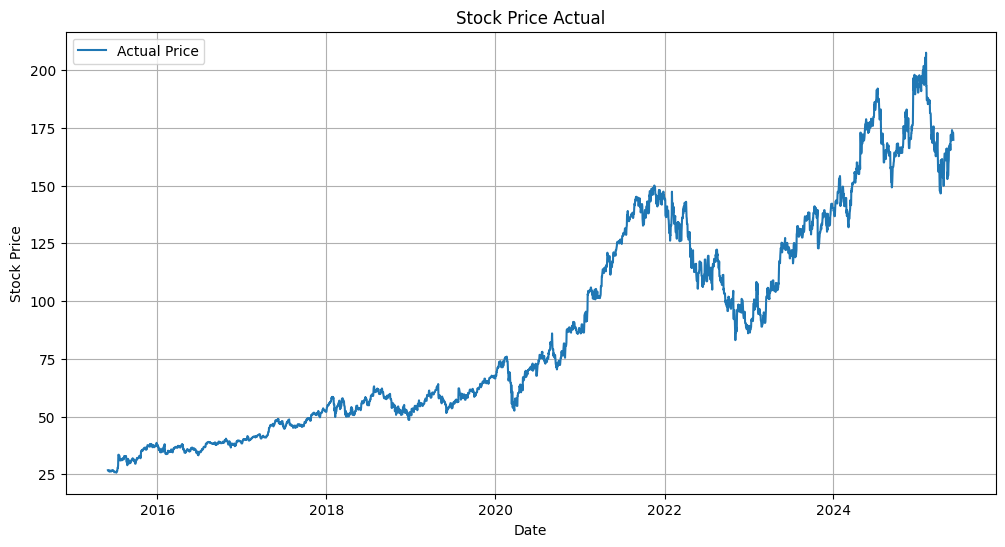

In [ ]:
# Vẽ đồ thị giá thực
dates = data.index[:]
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='Actual Price')
plt.title('Stock Price Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def directional_loss(y_true, y_pred):
    diff_true = y_true[:, 1:] - y_true[:, :-1]
    diff_pred = y_pred[:, 1:] - y_pred[:, :-1]
    return tf.reduce_mean(tf.maximum(0.0, -diff_true * diff_pred))  # penalize opposite direction

def combined_loss(y_true, y_pred):
    alpha = 0.4  # trọng số cho directional loss
    beta = 0.2   # trọng số cho underprediction penalty

    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    dir_loss = directional_loss(y_true, y_pred)

    under_penalty = tf.reduce_mean(tf.nn.relu(y_true - y_pred))  # chỉ phạt khi dự đoán thấp hơn thực tế

    return mse + alpha * dir_loss + beta * under_penalty

In [ ]:
# Step 3: Build LSTM model
def build_model(input_shape, units=50, output_steps=5):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(output_steps))  # Output shape = (batch_size, k)
    model.compile(optimizer='adam', loss=combined_loss)
    return model

**Step 4**: Tối ưu hóa bằng HC + SA

In [ ]:
# Prepare data
def create_dataset(data, window_size=60, k=5):
    X, y = [], []
    for i in range(window_size, len(data) - k + 1):  # ensure enough room for k steps
        X.append(data[i - window_size:i])
        y.append(data[i:i + k].flatten())  # output is a sequence of k steps
    return np.array(X), np.array(y)

In [ ]:
# Lấy dữ liệu gốc
close_prices = data['Close'].values.reshape(-1, 1)
total_len = len(close_prices)

# Chia theo 80% train, 10% val, 10% test
train_end = int(0.8 * total_len)
val_end = int(0.9 * total_len)

# ⚠️ Giữ lại 90 ngày trước khi chia để đủ cho mọi window_size
max_window_size = 90
train_raw = close_prices[:train_end]
val_raw = close_prices[train_end - max_window_size:val_end]
test_raw = close_prices[val_end - max_window_size:]

# Chuẩn hóa
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
val_scaled = scaler.transform(val_raw)
test_scaled = scaler.transform(test_raw)


Step 5: Chạy thuật toán HC + SA để tìm ra cá thể tốt nhất

In [ ]:
import random
import copy
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf

# ====================================
# 1. Các hàm phụ
# ====================================

def create_individual():
    """
    Tạo một cá thể ngẫu nhiên cho hyperparameter tuning:
      - window_size: int trong [30, 90]
      - units: int trong [32, 64, 128]
    Trả về dict {'window_size': ..., 'units': ...}
    """
    return {
        'window_size': random.randint(30, 90),
        'units': random.choice([64, 128, 256])
    }


def create_neighbor(ind):
    """
    Tạo một cá thể láng giềng (neighbor) từ ind hiện tại.
    Cơ chế đột biến:
      - 50% khả năng thay đổi window_size ±3 hoặc ±5 (giữ trong [30, 90])
      - 50% khả năng đổi sang một giá trị units khác trong [32, 64, 128]
    Trả về dict mới.
    """
    neighbor = copy.deepcopy(ind)
    if random.random() < 0.5:
        delta = random.choice([-5, -3, 3, 5])
        new_ws = neighbor['window_size'] + delta
        neighbor['window_size'] = max(30, min(90, new_ws))
    else:
        choices = [ 64, 128, 256]
        choices.remove(neighbor['units'])
        neighbor['units'] = random.choice(choices)
    return neighbor


def fitness(ind):
    """
    Tính MSE cho cá thể ind (dict có window_size, units).
    - Giảm epochs xuống 2 để nhanh.
    - Thêm verbose=0 cho model.fit/predict.
    - Nếu dataset trống hoặc có lỗi, trả về inf để phạt.
    """
    ws = ind['window_size']
    units = ind['units']

    try:
        X_train, y_train = create_dataset(train_scaled, ws)
        X_val, y_val     = create_dataset(val_scaled, ws)

        if len(X_train) == 0 or len(X_val) == 0:
            return float('inf')

        # Xây model (đã sửa build_model để khai báo Input layer nếu cần)
        model = build_model((ws, 1), units=units)

        model.fit(X_train, y_train, epochs=2, batch_size=32, verbose=0)
        preds = model.predict(X_val, verbose=0)
        return mean_squared_error(y_val, preds)

    except Exception as e:
        print(f"Warning: fitness failed for {ind}: {e}")
        return float('inf')

# 2. Hàm hill_climb_annealing (HC + SA)

def hill_climb_annealing(max_iterations=100,T_init=1.0,alpha=0.95,min_temperature=1e-3,target_mse=0.0015,random_seed=None):
    """
    Tìm best_hyperparams bằng Hill Climbing + Simulated Annealing.
    Args:
      - max_iterations: số bước neighbor proposals tối đa
      - T_init: nhiệt độ khởi đầu
      - alpha: hệ số giảm nhiệt (0 < alpha < 1)
      - min_temperature: dừng khi T < min_temperature
      - target_mse: nếu không None, dừng khi best_mse <= target_mse
      - random_seed: seed để tái lập kết quả

    Trả về:
      - best_individual: {'window_size', 'units'}
    """
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)

    # Khởi tạo
    current = create_individual()
    current_mse = fitness(current)
    best_individual = copy.deepcopy(current)
    best_mse = current_mse

    T = T_init
    iteration = 0
    print(f"Initial: ws={current['window_size']}, units={current['units']}, MSE={current_mse:.6f}")

    # Vòng lặp chính
    while iteration < max_iterations and T > min_temperature:
        iteration += 1

        neighbor = create_neighbor(current)
        neighbor_mse = fitness(neighbor)

        # Nếu neighbor tốt hơn, accept; ngược lại vẫn có thể accept theo SA
        if neighbor_mse < current_mse:
            accept = True
        else:
            Δ = neighbor_mse - current_mse
            p = math.exp(-Δ / T)
            accept = (random.random() < p)

        if accept:
            current = neighbor
            current_mse = neighbor_mse

            # Cập nhật best nếu cần
            if current_mse < best_mse:
                best_mse = current_mse
                best_individual = copy.deepcopy(current)
                print(f"Iter {iteration:3d}: New best → ws={best_individual['window_size']}, "
                      f"units={best_individual['units']}, MSE={best_mse:.6f}, T={T:.4f}")

        # Giảm nhiệt độ
        T *= alpha

        # Dừng sớm nếu target_mse đã đạt
        if (target_mse is not None) and (best_mse <= target_mse):
            print(f"\nEarly stopping at iter {iteration}: reached target MSE ≤ {target_mse:.6f}")
            break

    print(f"\nFinal best: ws={best_individual['window_size']}, units={best_individual['units']}, MSE={best_mse:.6f}")
    return best_individual

In [ ]:
# HC + SA optimization
best_params = hill_climb_annealing()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Initial: ws=59, units=128, MSE=0.002132


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Iter   8: New best → ws=53, units=128, MSE=0.001811, T=0.6983


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iter   9: New best → ws=50, units=128, MSE=0.001799, T=0.6634


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Iter  16: New best → ws=30, units=128, MSE=0.001752, T=0.4633


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Iter  40: New best → ws=30, units=128, MSE=0.001724, T=0.1353


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Iter  98: New best → ws=45, units=128, MSE=0.001711, T=0.0069


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Final best: ws=45, units=128, MSE=0.001711


**Step 6**: Huấn luyện và tính RMSE đối với cá thể tốt nhất được chọn

In [ ]:
from keras.callbacks import EarlyStopping

# 1. Lấy dữ liệu gốc (chưa chuẩn hóa)
close_prices = data['Close'].values.reshape(-1, 1)

# 2. Chia dữ liệu theo tỉ lệ 80% train, 10% val, 10% test
total_len = len(close_prices)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9)

train_prices = close_prices[:train_end]
val_prices = close_prices[train_end - best_params['window_size']:val_end]
test_prices = close_prices[val_end - best_params['window_size']:]  # giữ lại window_size ngày

# 3. Fit scaler trên tập train và transform cả 3 phần
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_val = scaler.transform(val_prices)
scaled_test = scaler.transform(test_prices)

# 4. Tạo dataset
k=5
X_train, y_train = create_dataset(scaled_train, best_params['window_size'], k)
X_val, y_val = create_dataset(scaled_val, best_params['window_size'], k)
X_test, y_test = create_dataset(scaled_test, best_params['window_size'], k)

# 5. Gộp train + val để train mô hình cuối cùng
X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# 6. Xây mô hình
model = build_model((best_params['window_size'], 1), best_params['units'])

# 7. EarlyStopping (monitor trên `loss` vì không có val)
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# 8. Huấn luyện trên train + val
model.fit(
    X_final_train, y_final_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# 9. Dự đoán trên test set và tính RMSE
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("✅ Test RMSE:", rmse)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0628
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036
Epoch 13/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036
Epoch 14/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045
Epoch 15/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


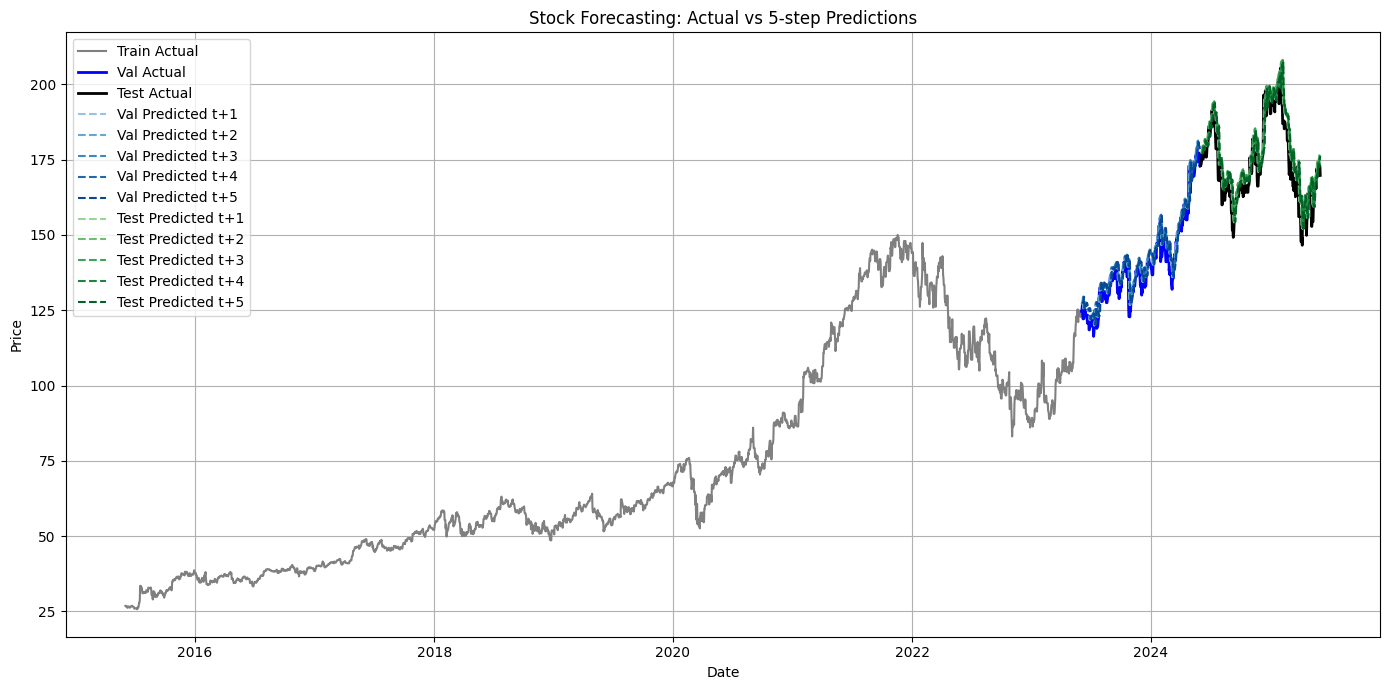

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
val_preds = model.predict(X_val)

def plot_all_forecasts(data, scaler, best_params, y_val, val_preds, y_test, test_preds):
    window_size = best_params['window_size']
    k = y_val.shape[1]

    total_len = len(data)
    train_end = int(0.8 * total_len)
    val_end = int(0.9 * total_len)

    # --- 1. Lấy index gốc ---
    train_dates = data.index[:train_end]

    val_start_index = train_end - window_size
    test_start_index = val_end - window_size

    # --- 2. Giải scale ---
    y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    val_preds_rescaled = scaler.inverse_transform(val_preds.reshape(-1, 1)).reshape(val_preds.shape)

    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    test_preds_rescaled = scaler.inverse_transform(test_preds.reshape(-1, 1)).reshape(test_preds.shape)

    # --- 3. Tạo dict giá thực ---
    def get_actual_dict(y_rescaled, start_idx):
        actual_dict = defaultdict(list)
        for i in range(len(y_rescaled)):
            start = start_idx + i + window_size
            for j in range(y_rescaled.shape[1]):
                date_idx = start + j
                if date_idx < len(data):
                    date = data.index[date_idx]
                    actual_dict[date].append(y_rescaled[i][j])
        return actual_dict

    actual_val = get_actual_dict(y_val_rescaled, val_start_index)
    actual_test = get_actual_dict(y_test_rescaled, test_start_index)

    # --- 4. Dự đoán từng bước ---
    def get_pred_lines(preds_rescaled, start_idx):
        pred_step_dict = [defaultdict(list) for _ in range(k)]
        for i in range(len(preds_rescaled)):
            start = start_idx + i + window_size
            for j in range(k):
                date_idx = start + j
                if date_idx < len(data):
                    date = data.index[date_idx]
                    pred_step_dict[j][date].append(preds_rescaled[i][j])
        pred_lines = []
        for j in range(k):
            common_dates = sorted(set(pred_step_dict[j].keys()))
            pred_avg = np.array([np.mean(pred_step_dict[j][d]) for d in common_dates])
            pred_lines.append((common_dates, pred_avg))
        return pred_lines

    val_pred_lines = get_pred_lines(val_preds_rescaled, val_start_index)
    test_pred_lines = get_pred_lines(test_preds_rescaled, test_start_index)

    # --- 5. Plot ---
    plt.figure(figsize=(14, 7))

    # Train thực tế
    plt.plot(train_dates, data['Close'][:train_end], label='Train Actual', color='gray', linewidth=1.5)

    # Val thực tế
    val_actual_dates = sorted(actual_val.keys())
    val_actual_avg = np.array([np.mean(actual_val[d]) for d in val_actual_dates])
    plt.plot(val_actual_dates, val_actual_avg, label='Val Actual', color='blue', linewidth=2)

    # Test thực tế
    test_actual_dates = sorted(actual_test.keys())
    test_actual_avg = np.array([np.mean(actual_test[d]) for d in test_actual_dates])
    plt.plot(test_actual_dates, test_actual_avg, label='Test Actual', color='black', linewidth=2)

    # Các bước dự đoán val
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, k))
    for j, (dates, preds_j) in enumerate(val_pred_lines):
        plt.plot(dates, preds_j, label=f'Val Predicted t+{j+1}', color=colors[j], linestyle='--')

    # Các bước dự đoán test
    colors = plt.cm.Greens(np.linspace(0.4, 0.9, k))
    for j, (dates, preds_j) in enumerate(test_pred_lines):
        plt.plot(dates, preds_j, label=f'Test Predicted t+{j+1}', color=colors[j], linestyle='--')

    plt.title(f'Stock Forecasting: Actual vs {k}-step Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_all_forecasts(data, scaler, best_params, y_val, val_preds, y_test, preds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


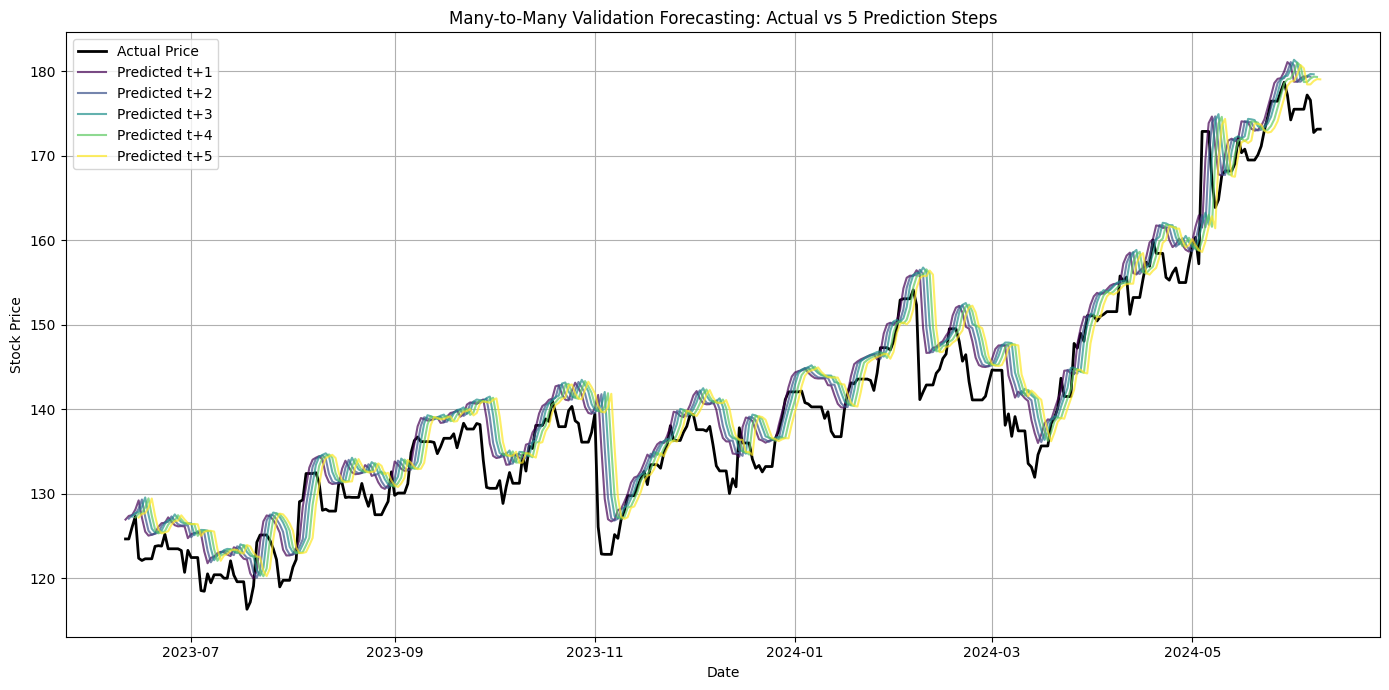

In [ ]:
# Dự đoán trên tập validation
val_preds = model.predict(X_val)
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Rescale val ground truth và dự đoán
y_val_2d = y_val.reshape(-1, 1)
val_preds_2d = val_preds.reshape(-1, 1)

y_val_rescaled = scaler.inverse_transform(y_val_2d).reshape(y_val.shape)
val_preds_rescaled = scaler.inverse_transform(val_preds_2d).reshape(val_preds.shape)

# -------------------------------
# 2. Tạo actual_dict từ y_val_rescaled
actual_dict = defaultdict(list)
val_start_index = len(data) - len(y_test) - len(y_val) - best_params['window_size']

for i in range(len(y_val_rescaled)):
    start = val_start_index + i + best_params['window_size']
    for j in range(y_val_rescaled.shape[1]):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            actual_dict[date].append(y_val_rescaled[i][j])

actual_dates = sorted(actual_dict.keys())
actual_avg = np.array([np.mean(actual_dict[d]) for d in actual_dates])

# -------------------------------
# 3. Dự đoán từng bước t+1, ..., t+k
k = val_preds_rescaled.shape[1]
pred_step_dict = [defaultdict(list) for _ in range(k)]

for i in range(len(val_preds_rescaled)):
    start = val_start_index + i + best_params['window_size']
    for j in range(k):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            pred_step_dict[j][date].append(val_preds_rescaled[i][j])

# Trung bình từng bước
pred_lines = []
step_mae = []
for j in range(k):
    common_dates = sorted(set(pred_step_dict[j].keys()) & set(actual_dict.keys()))
    pred_avg = np.array([np.mean(pred_step_dict[j][d]) for d in common_dates])
    actual_avg_step = np.array([np.mean(actual_dict[d]) for d in common_dates])
    pred_lines.append((common_dates, pred_avg))
    step_mae.append(np.mean(np.abs(pred_avg - actual_avg_step)))

# -------------------------------
# 4. Plot
plt.figure(figsize=(14, 7))

# Đường thực tế
plt.plot(actual_dates, actual_avg, label='Actual Price', color='black', linewidth=2)

# Các đường dự đoán t+1 đến t+k
colors = plt.cm.viridis(np.linspace(0, 1, k))
for j in range(k):
    dates, preds_j = pred_lines[j]
    plt.plot(dates, preds_j, label=f'Predicted t+{j+1}', color=colors[j], alpha=0.7)

plt.title(f'Many-to-Many Validation Forecasting: Actual vs {k} Prediction Steps')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

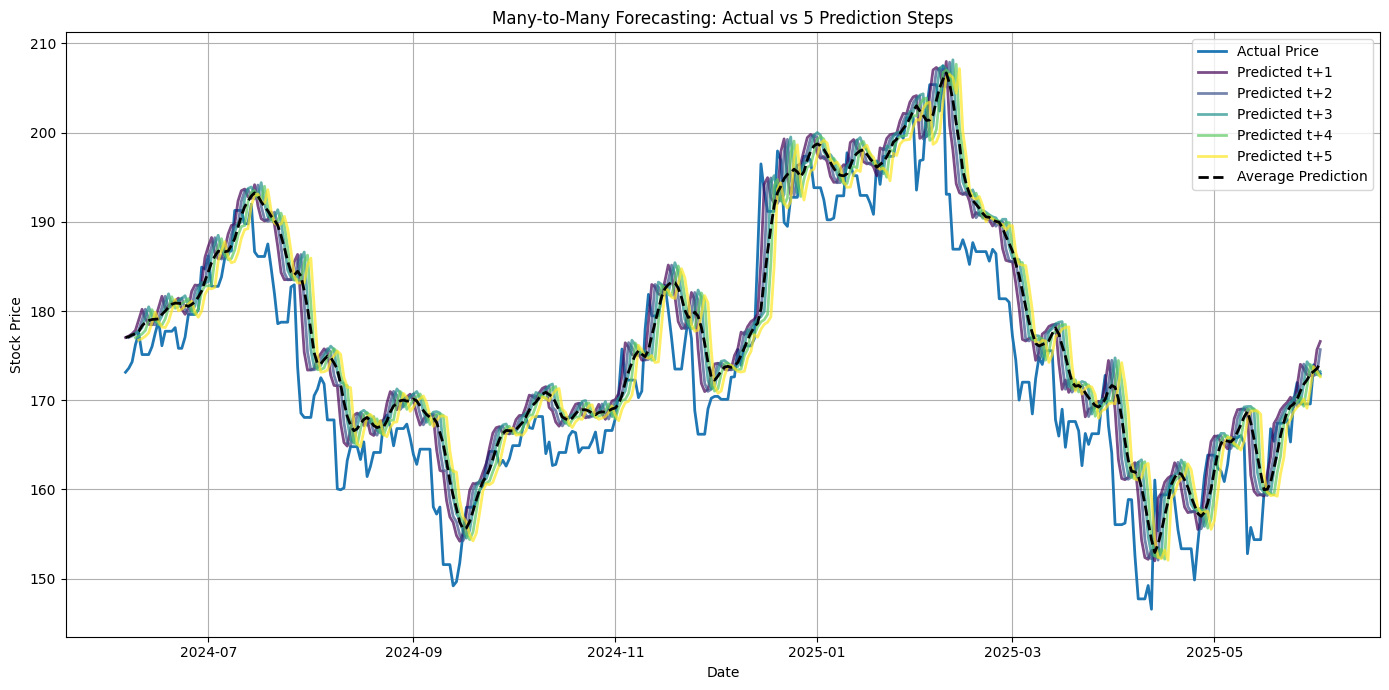

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Reshape cho inverse transform
y_test_2d = y_test.reshape(-1, 1)
preds_2d = preds.reshape(-1, 1)

y_test_rescaled = scaler.inverse_transform(y_test_2d).reshape(y_test.shape)
preds_rescaled = scaler.inverse_transform(preds_2d).reshape(preds.shape)

# ----------------------------
# Chuẩn bị actual price (trung bình nếu trùng)
actual_dict = defaultdict(list)
start_index = len(data) - len(y_test_rescaled) - best_params['window_size']

for i in range(len(y_test_rescaled)):
    start = start_index + i + best_params['window_size']
    for j in range(y_test_rescaled.shape[1]):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            actual_dict[date].append(y_test_rescaled[i][j])

# Trung bình giá thực tế nếu trùng
actual_dates = sorted(actual_dict.keys())
actual_avg = np.array([np.mean(actual_dict[d]) for d in actual_dates])

# ----------------------------
# Dự đoán theo từng bước t+1, t+2, ..., t+k
k = preds_rescaled.shape[1]
pred_step_dict = [defaultdict(list) for _ in range(k)]

for i in range(len(preds_rescaled)):
    start = start_index + i + best_params['window_size']
    for j in range(k):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            pred_step_dict[j][date].append(preds_rescaled[i][j])

# Trung bình từng bước + tính MAE
pred_lines = []
step_mae = []
for j in range(k):
    common_dates = sorted(set(pred_step_dict[j].keys()) & set(actual_dict.keys()))
    pred_avg = np.array([np.mean(pred_step_dict[j][d]) for d in common_dates])
    actual_avg_step = np.array([np.mean(actual_dict[d]) for d in common_dates])
    pred_lines.append((common_dates, pred_avg))
    step_mae.append(np.mean(np.abs(pred_avg - actual_avg_step)))

# ----------------------------
# Trung bình tất cả bước dự đoán
combined_pred_dict = defaultdict(list)
for j in range(k):
    for date, values in pred_step_dict[j].items():
        combined_pred_dict[date].extend(values)

common_avg_dates = sorted(set(combined_pred_dict.keys()) & set(actual_dict.keys()))
avg_pred_line = np.array([np.mean(combined_pred_dict[d]) for d in common_avg_dates])

# ----------------------------
# Plot
plt.figure(figsize=(14, 7))

# Đường giá thực tế
plt.plot(actual_dates, actual_avg, label='Actual Price', linewidth=2)

# Các đường dự đoán t+1 đến t+k
colors = plt.cm.viridis(np.linspace(0, 1, k))
for j in range(k):
    dates, preds_j = pred_lines[j]
    plt.plot(dates, preds_j, label=f'Predicted t+{j+1}', color=colors[j], alpha=0.7, linewidth=2)

# Đường trung bình các bước dự đoán
plt.plot(common_avg_dates, avg_pred_line, label='Average Prediction', color='black', linestyle='--', linewidth=2)

plt.title(f'Many-to-Many Forecasting: Actual vs {k} Prediction Steps')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Tính MAE và MAPE cho đường dự đoán trung bình
common_actual_avg = np.array([np.mean(actual_dict[d]) for d in common_avg_dates])

# MAE: sai số tuyệt đối trung bình
avg_mae = np.mean(np.abs(avg_pred_line - common_actual_avg))

# MAPE: sai số phần trăm tuyệt đối trung bình
# Tránh chia cho 0 bằng cách thêm epsilon nhỏ
epsilon = 1e-8
avg_mape = np.mean(np.abs((common_actual_avg - avg_pred_line) / (common_actual_avg + epsilon))) * 100

print(f"\n➡️  MAE (Average Prediction): {avg_mae:.4f} USD")
print(f"➡️  MAPE (Average Prediction): {avg_mape:.2f}%")



➡️  MAE (Average Prediction): 4.4188 USD
➡️  MAPE (Average Prediction): 2.60%


Step t+1: MAE = 3.8674 dollars
Step t+2: MAE = 4.2339 dollars
Step t+3: MAE = 4.7762 dollars
Step t+4: MAE = 4.9615 dollars
Step t+5: MAE = 5.2315 dollars


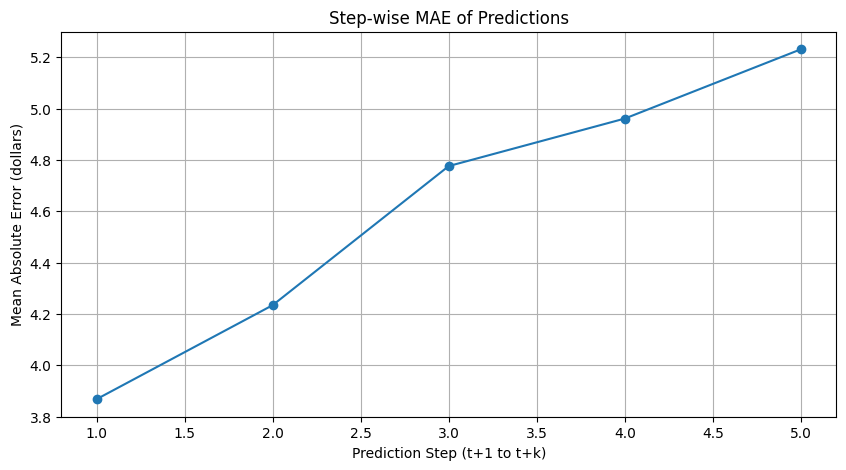

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# preds, y_test đã rescale rồi (preds_rescaled, y_test_rescaled)
# Giả sử: preds_rescaled.shape = (num_samples, k)
#         y_test_rescaled.shape = (num_samples, k)

k = preds_rescaled.shape[1]
step_wise_mae = []

for step in range(k):
    mae = mean_absolute_error(y_test_rescaled[:, step], preds_rescaled[:, step])
    step_wise_mae.append(mae)

# In ra từng step
for i, mae in enumerate(step_wise_mae):
    print(f"Step t+{i+1}: MAE = {mae:.4f} dollars")

# Vẽ biểu đồ MAE theo từng bước
plt.figure(figsize=(10, 5))
plt.plot(range(1, k + 1), step_wise_mae, marker='o')
plt.title("Step-wise MAE of Predictions")
plt.xlabel("Prediction Step (t+1 to t+k)")
plt.ylabel("Mean Absolute Error (dollars)")
plt.grid(True)
plt.show()